In [1]:
import os
import csv
import json
import pickle as pkl

wdir = '../results/hpsearch-2021-09-06/best/1_run_168/evalmockAllStates/step_0/'

with open(os.path.join(wdir, 'sim.pkl'), 'rb') as f:
    sim = pkl.load(f)

ts = []
with open(os.path.join(wdir, 'ActionsRewards.txt')) as f:
    for row in csv.reader(f, delimiter='\t'):
        ts.append(float(row[0]))
        
ts.append(ts[-1] + 50)

spkt = sim['simData']['spkt']
spkid = sim['simData']['spkid']

In [24]:
input_pop = list(range(0, 80))
space_between = 50.0 # ms

prev_st = -1
curr_step = -1
activations = []

for st, sid in zip(spkt, spkid):
    if st < 150:
        continue

    if st > prev_st + space_between:
        curr_step += 1
        activations.append({ 'es': [], 'rest': [], 'min': spkt[-1] + 100, 'max': -1})
    activations[curr_step]['es' if sid in input_pop else 'rest'].append(sid)
    activations[curr_step]['min'] = min(st, activations[curr_step]['min'])
    activations[curr_step]['max'] = max(st, activations[curr_step]['max'])
    
    prev_st = st
    
assert len(activations) == 8000

In [25]:
print('len', len(activations))
print(activations[2012])

len 8000
{'es': [45.0, 20.0, 60.0, 12.0, 45.0, 20.0, 60.0, 12.0, 45.0, 20.0, 60.0, 12.0], 'rest': [112.0, 85.0, 82.0, 111.0, 134.0, 156.0, 112.0, 85.0, 82.0, 111.0, 179.0, 156.0, 134.0, 154.0, 149.0], 'min': 300763.92844473466, 'max': 300808.4419757773}


In [18]:
diffs = [act['max'] - act['min']  for act in activations]

In [21]:
min(diffs), max(diffs)

(22.37256519217044, 46.929021553485654)

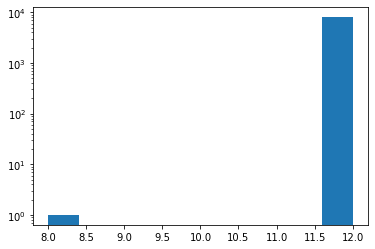

In [23]:
import matplotlib.pyplot as plt

es_acts = [len(act['es']) for act in activations]

plt.hist(es_acts)
plt.yscale('log')
plt.show()

In [52]:
import os
import csv
import json
import pickle as pkl
from tqdm import tqdm

input_pop = list(range(0, 80))
space_between = 50.0 # ms

all_activations = []
for STEP_IDX in tqdm(range(20), total=20):
#     wdir = '../results/hpsearch-2021-09-06/best/1_run_168/evalmockAllStates/step_{}/'.format(STEP_IDX)
    wdir = '../results/20210907-ES1500it/evalmockAllStates/step_{}/'.format(STEP_IDX)

    with open(os.path.join(wdir, 'sim.pkl'), 'rb') as f:
        sim = pkl.load(f)

    ts = []
    with open(os.path.join(wdir, 'ActionsRewards.txt')) as f:
        for row in csv.reader(f, delimiter='\t'):
            ts.append(float(row[0]))

    ts.append(ts[-1] + 50)

    spkt = sim['simData']['spkt']
    spkid = sim['simData']['spkid']

    prev_st = -1
    curr_step = -1
    activations = []

    for st, sid in zip(spkt, spkid):
        if st < 150:
            continue

        if st > prev_st + space_between:
            curr_step += 1
            activations.append({ 'es': [], 'rest': [], 'min': spkt[-1] + 100, 'max': -1})
        activations[curr_step]['es' if sid in input_pop else 'rest'].append(sid)
        activations[curr_step]['min'] = min(st, activations[curr_step]['min'])
        activations[curr_step]['max'] = max(st, activations[curr_step]['max'])

        prev_st = st

    assert len(activations) == 8000
    
    all_activations.extend(activations)

100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


In [27]:
print(len(all_activations))

160000


In [154]:
pop_left = {k: True for k in range(140, 160)}
pop_right = {k: True for k in range(160, 180)}

for act in tqdm(all_activations):
    moves = [0, 0, 0]
    for cid in act['rest']:
        moves[0 if cid in pop_left else (1 if cid in pop_right else 2)] += 1
    if moves[0] == 0 and moves[1] == 0:
        act['move'] = '0'
    elif moves[0] == moves[1]:
        act['move'] = 'u'
    elif moves[0] < moves[1]:
        act['move'] = 'r'
    elif moves[0] > moves[1]:
        act['move'] = 'l'
    else:
        assert False

100%|██████████| 160000/160000 [00:02<00:00, 64391.14it/s]


In [133]:
es_all_activations = all_activations
# stdp_all_activations = all_activations

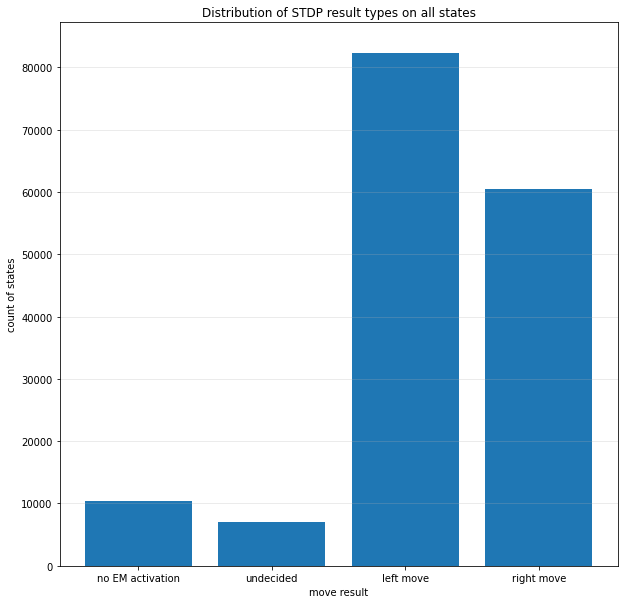

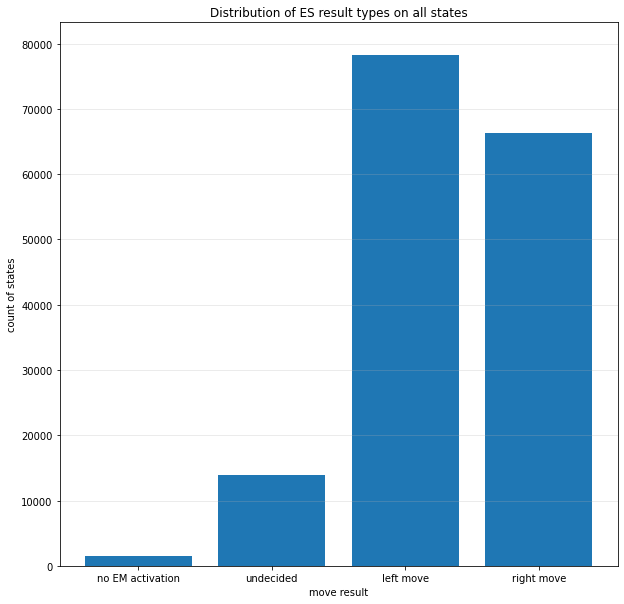

In [155]:
from collections import Counter

for activations, name in [[stdp_all_activations, 'STDP'], [es_all_activations, 'ES']]:
    keys = ['0', 'u', 'l', 'r']
    keys_names = ['no EM activation', 'undecided', 'left move', 'right move']

    moves = Counter(''.join([act['move'] for act in activations]))
#     moves

    x = list(range(len(keys)))
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', alpha=0.3)
    plt.bar(x, [moves[k] for k in keys])
    plt.xticks(x, keys_names)
    plt.ylim(0, max(moves.values()) + 5000)
    plt.xlabel('move result')
    plt.ylabel('count of states')
    plt.title('Distribution of {} result types on all states'.format(name))
    plt.show()

In [156]:
import numpy as np

M = np.zeros((len(keys), len(keys)))

for act_stdp, act_es in zip(stdp_all_activations, es_all_activations):
    m1 = keys.index(act_stdp['move'])
    m2 = keys.index(act_es['move'])
    M[m1][m2] += 1
    
M

array([[  168.,  1078.,  4561.,  4562.],
       [   70.,   672.,  3609.,  2621.],
       [  664.,  6948., 48629., 26004.],
       [  569.,  5231., 21496., 33118.]])

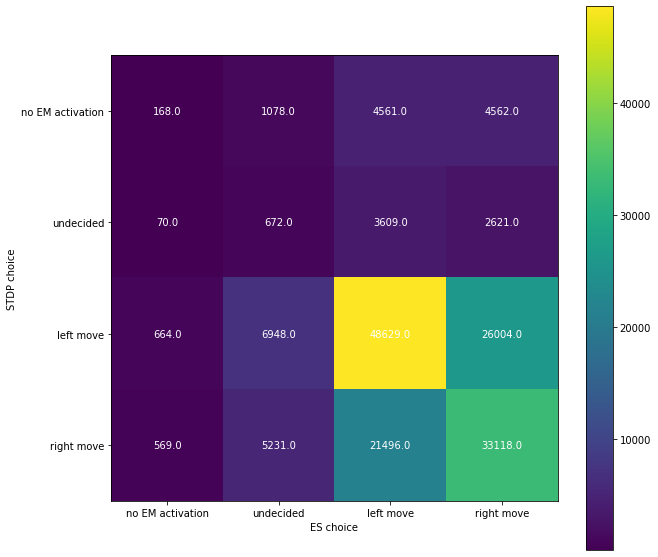

In [157]:
fig = plt.figure(figsize=(10,10))
plt.imshow(M)
plt.xticks(range(len(keys)), keys_names)
plt.yticks(range(len(keys)), keys_names)

# Loop over data dimensions and create text annotations.
for i in range(len(keys)):
    for j in range(len(keys)):
        text = plt.text(j, i, M[i, j],
                       ha="center", va="center", color="w")
        
plt.colorbar()

plt.ylabel('STDP choice')
plt.xlabel('ES choice')

plt.show()

In [158]:
M[0]

array([ 168., 1078., 4561., 4562.])

In [159]:
print('similar moves', sum(np.diag(M)))
print('percentage', sum(np.diag(M)) / np.sum(M))

similar moves 82587.0
percentage 0.51616875


In [160]:

# for act_stdp, act_es in zip(stdp_all_activations, es_all_activations):

all_influences = {}
# for all_activations, name in [[stdp_all_activations, 'stdp'], [es_all_activations, 'es']]:
    
all_activations = stdp_all_activations

# TODO: loop over all activations once only and create the matrix from that

influence = []
for cid in tqdm(range(200)):
    activated = np.zeros((len(keys)))
    total = np.zeros((len(keys)))
    for act in all_activations:
        if cid in act['es'] or cid in act['rest']:
            activated[keys.index(act['move'])] += 1
        total[keys.index(act['move'])] += 1
    influence.append(activated / total)

all_influences[name] = influence

100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


In [167]:
activated

array([    0.,  1066., 11924., 32113.])

In [168]:
total

array([10369.,  6972., 82245., 60414.])

In [117]:
from neurosim.tools.utils import _get_pop_name

sorted_min_ids = [('stimModES', 200),
 ('IML', 190),
 ('IM', 180),
 ('EM-RIGHT', 160),
 ('EM-LEFT', 140),
 ('IAL', 130),
 ('IA', 120),
 ('EA', 80),
 ('ES', 0)]

In [161]:
es_c_stats = c_stats

In [172]:
c_stats = []

for i, inf in enumerate(influence):
    power = inf[2:].sum()
    norm = inf[2:] / power
    left_pref = norm[0]
#     right_pref = norm[3]

    pop_name = _get_pop_name(i, sorted_min_ids)
    c_stats.append([i, pop_name, left_pref, power])


In [173]:
sorted(c_stats, key=lambda x:x[3])

[[61, 'ES', 0.5227551839720371, 0.0825464016204174],
 [75, 'ES', 0.49548340199423696, 0.08392425415583897],
 [60, 'ES', 0.7649330331381402, 0.08449909376895264],
 [78, 'ES', 0.6580180624771285, 0.08470270677344259],
 [74, 'ES', 0.6689739184210981, 0.08480589531358196],
 [79, 'ES', 0.6481655265746006, 0.08872902451834846],
 [34, 'ES', 0.47786588582818834, 0.08971535398998778],
 [24, 'ES', 0.5571199509250605, 0.09048385219135512],
 [36, 'ES', 0.5243219257433053, 0.09127410133861388],
 [63, 'ES', 0.7457437195517811, 0.0918581581603321],
 [3, 'ES', 0.50698415153315, 0.09209315169672382],
 [64, 'ES', 0.8438455867338776, 0.09391649318891092],
 [39, 'ES', 0.546612137585526, 0.09393605243643771],
 [62, 'ES', 0.5340394533890035, 0.09403016625855493],
 [0, 'ES', 0.46498287692670776, 0.09476363773892296],
 [41, 'ES', 0.46735777682529284, 0.09490647669870525],
 [22, 'ES', 0.4725052380963159, 0.09523639613277902],
 [47, 'ES', 0.5780221110440515, 0.09543657004253484],
 [20, 'ES', 0.353374427488398, 

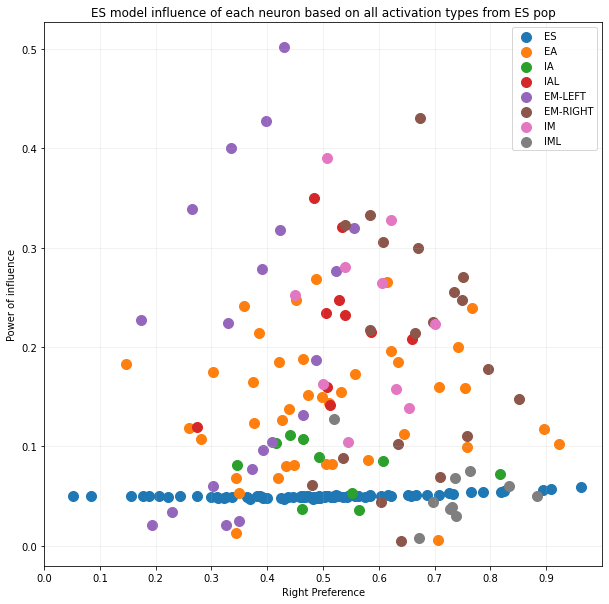

In [152]:

indices = list(range(len(sorted_min_ids)-1, -1, -1))
pops = [sorted_min_ids[i][0] for i in indices]

plt.figure(figsize=(10,10))

for pop_name in pops:
    pop_stats = [(left_pref, power) for _,pname,left_pref,power in c_stats if pname == pop_name]
    xvals = [1.0-x for x,y in pop_stats]
    yvals = [y / 2.0 for x,y in pop_stats]
    plt.scatter(xvals, yvals, s=100.0)
    
plt.legend(pops[:-1])
plt.xlabel('Right Preference')
plt.ylabel('Power of influence')
plt.xlim(0, 1.0)
plt.xticks(np.arange(0, 1.0, 0.1))
plt.grid(alpha=0.2)
plt.title('ES model influence of each neuron based on all activation types from ES pop')
plt.show()

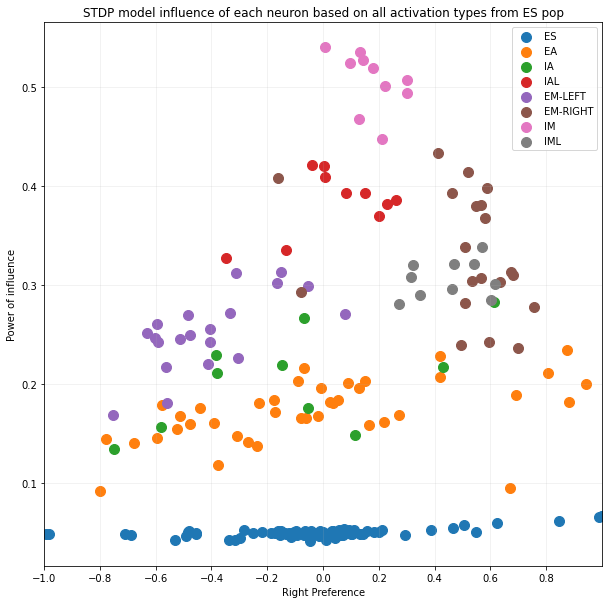

In [174]:

indices = list(range(len(sorted_min_ids)-1, -1, -1))
pops = [sorted_min_ids[i][0] for i in indices]

plt.figure(figsize=(10,10))

for pop_name in pops:
    pop_stats = [(left_pref, power) for _,pname,left_pref,power in c_stats if pname == pop_name]
    xvals = [(0.5-x)*2 for x,y in pop_stats]
    yvals = [y / 2.0 for x,y in pop_stats]
    plt.scatter(xvals, yvals, s=100.0)
    
plt.legend(pops[:-1])
plt.xlabel('Right Preference')
plt.ylabel('Power of influence')
plt.xlim(0, 1.0)
plt.xticks(np.arange(-1, 1.0, 0.2))
plt.grid(alpha=0.2)
plt.title('STDP model influence of each neuron based on all activation types from ES pop')
plt.show()

[8, 7, 6, 5, 4, 3, 2, 1, 0]

Previous, code for only 1 activation on ES

In [3]:
tidx = 0 # index of the place in the step-wise time increment
curr_sid = None
curr_tidx = None

causal_graph = {}
curr_sid = None
curr_tidx = None

verbose = True

for st, sid in zip(spkt, spkid):
    if st < 150:
        continue
#     if st < 24216:
#         continue
    if verbose: print(st, sid)
    if st > ts[tidx]:
        if verbose: print('incr', ts[tidx])
        tidx += 1
    while st > ts[tidx]:
        if verbose: print('incr++', ts[tidx])
        curr_sid = None
        curr_tidx = None
        tidx += 1
    if curr_sid == None:
        curr_sid = sid
        curr_tidx = tidx
        if curr_sid in causal_graph:
            print('Stopping at {} of spkid {}'.format(st, sid))
            break
    if curr_sid not in causal_graph:
        causal_graph[curr_sid] = [[]]
    if tidx - curr_tidx == len(causal_graph[curr_sid]):
        causal_graph[curr_sid].append([])
    causal_graph[curr_sid][tidx - curr_tidx].append(sid)
    if verbose: print('curr_sid', curr_sid)
    

170.97271027886944 20.0
incr 49.8
incr++ 99.6
incr++ 149.4
curr_sid 20.0
171.02646230435315 40.0
curr_sid 20.0
171.0697685705801 60.0
curr_sid 20.0
171.17599933464638 0.0
curr_sid 20.0
190.97271027886944 20.0
curr_sid 20.0
191.02646230435315 40.0
curr_sid 20.0
191.0697685705801 60.0
curr_sid 20.0
191.17599933464638 0.0
curr_sid 20.0
193.31398293536296 103.0
curr_sid 20.0
210.97271027886944 20.0
incr 199.2
curr_sid 20.0
211.02646230435315 40.0
curr_sid 20.0
211.0697685705801 60.0
curr_sid 20.0
211.17599933464638 0.0
curr_sid 20.0
319.95446467032787 1.0
incr 249.0
incr++ 298.8
curr_sid 1.0
319.97271027886944 20.0
curr_sid 1.0
320.0264623043531 40.0
curr_sid 1.0
320.0697685705801 60.0
curr_sid 1.0
339.95446467032787 1.0
curr_sid 1.0
339.97271027886944 20.0
curr_sid 1.0
340.0264623043531 40.0
curr_sid 1.0
340.0697685705801 60.0
curr_sid 1.0
342.1097201978532 119.0
curr_sid 1.0
342.19991871998644 84.0
curr_sid 1.0
344.3070278684359 143.0
curr_sid 1.0
359.95446467032787 1.0
incr 348.6
curr_s

In [98]:
causal_graph

{0.0: [[0.0]],
 1.0: [[1.0, 1.0]],
 2.0: [[2.0, 2.0]],
 3.0: [[3.0, 3.0]],
 4.0: [[4.0, 4.0]],
 5.0: [[5.0, 5.0]],
 6.0: [[6.0, 6.0]],
 7.0: [[7.0, 7.0]],
 8.0: [[8.0, 8.0]],
 9.0: [[9.0, 9.0]],
 10.0: [[10.0, 10.0]],
 11.0: [[11.0, 11.0]],
 12.0: [[12.0, 12.0]],
 13.0: [[13.0, 13.0]],
 14.0: [[14.0, 14.0]],
 15.0: [[15.0, 15.0]],
 16.0: [[16.0, 16.0]],
 17.0: [[17.0, 17.0]],
 18.0: [[18.0, 18.0]],
 19.0: [[19.0, 19.0]],
 20.0: [[20.0, 20.0]],
 21.0: [[21.0, 21.0]],
 22.0: [[22.0, 22.0]],
 23.0: [[23.0, 23.0]],
 24.0: [[24.0, 24.0]],
 25.0: [[25.0, 25.0, 118.0]],
 26.0: [[26.0, 26.0]],
 27.0: [[27.0, 117.0, 27.0, 117.0, 95.0, 163.0]],
 28.0: [[28.0, 28.0]],
 29.0: [[29.0, 29.0]],
 30.0: [[30.0,
   104.0,
   116.0,
   96.0,
   153.0,
   141.0,
   30.0,
   92.0,
   104.0,
   103.0,
   116.0,
   96.0,
   97.0,
   138.0,
   141.0,
   133.0,
   168.0,
   136.0,
   132.0,
   159.0,
   146.0,
   178.0,
   139.0,
   186.0]],
 31.0: [[31.0, 31.0]],
 32.0: [[32.0, 32.0]],
 33.0: [[33.0,
   94.0,

In [96]:
for i1,i2 in zip(sorted(list(causal_graph.keys())), range(80)):
    assert i1 == i2

In [134]:
for st, sid in zip(spkt, spkid):
#     if st > 300:
        print(st, sid)

171.09560217002974 9.0
171.16210226808624 33.0
173.17214285671426 94.0
173.25787819310605 114.0
173.3098406916694 106.0
191.09560217002974 9.0
191.16210226808624 33.0
193.17214285671426 94.0
193.1784614927651 112.0
193.2276382321893 87.0
193.25787819310605 114.0
195.10832839442688 168.0
195.15412902218424 175.0
195.18852016218273 158.0
195.32454181515504 142.0
320.09560217002974 9.0
340.09560217002974 9.0
360.09560217002974 9.0
369.96761456025587 53.0
380.09560217002974 9.0
389.96761456025587 53.0
400.09560217002974 9.0
420.09560217002974 9.0
440.09560217002974 9.0
460.09560217002974 9.0
480.09560217002974 9.0
500.09560217002974 9.0
520.0956021700298 9.0
540.0956021700298 9.0
560.0956021700298 9.0
580.0956021700298 9.0
600.0956021700298 9.0
620.0956021700298 9.0
640.0956021700298 9.0
660.0956021700298 9.0
680.0956021700298 9.0
700.0956021700298 9.0
720.0956021700298 9.0
740.0956021700298 9.0
818.0749581671611 66.0
818.1621022680863 33.0
819.9455635261849 98.0
819.9943070893189 87.0
820

In [ ]:
spkid

In [144]:
from neurosim.game_interface import GameInterface
import gym

env = gym.make('CartPole-v1')

class MockAIGame:
    observations = []
    rewards = []
    env = None

    def __init__(self, env):
        self.env = env
        
config = None
with open('../config.json') as f:
    config = json.load(f)

game = MockAIGame(env)
gi = GameInterface(game, config)

In [198]:
import os
import csv
import json
import pickle as pkl

wdir = '../results/hpsearch-2021-09-06/best/1_run_168/evaluation_8/'

with open(os.path.join(wdir, 'sim.pkl'), 'rb') as f:
    sim = pkl.load(f)

ts = []
obs_fr = []
with open(os.path.join(wdir, 'ActionsRewards.txt')) as f:
    for row in csv.reader(f, delimiter='\t'):
        ts.append(float(row[0]))
        obs = json.loads(row[3])
        
        game.observations = [obs]
        f_r = gi.input_firing_rates()
        f_ind = (f_r > 0).nonzero()[0]
        obs_fr.append(f_ind)
        
ts.append(ts[-1] + 50)

spkt = sim['simData']['spkt']
spkid = sim['simData']['spkid']

In [201]:
tidx = 0 # index of the place in the step-wise time increment

es_spks_at_times = {}
for st, sid in zip(spkt, spkid):
    if sid < 80:
        while st > ts[tidx]:
            tidx += 1
#         print('\t'.join([str(k) for k in [ts[tidx-1], round(st, 2), ts[tidx], sid]]))
        if tidx not in es_spks_at_times:
            es_spks_at_times[tidx] = []
        es_spks_at_times[tidx].append(sid)
        es_spks_at_times[tidx] = sorted(es_spks_at_times[tidx])
        
print(len(es_spks_at_times))

14093


In [181]:
for idx, (k,v) in enumerate(es_spks_at_times.items()):
    print('---', k, [int(s) for s in sorted(list(set(v)))], obs_fr[idx-1])

--- 0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] [17 39 59 73]
--- 1 [9, 33, 53, 66] [ 9 33 53 66]
--- 2 [9, 30, 52, 69] [ 9 30 52 69]
--- 3 [9, 27, 52, 72] [ 9 27 52 72]
--- 4 [9, 30, 52, 53, 70] [ 9 30 53 70]
--- 5 [9, 33, 53, 67] [ 9 33 53 67]
--- 6 [9, 30, 52, 70] [ 9 30 52 70]
--- 7 [9, 33, 53, 67] [ 9 33 53 67]
--- 8 [10, 30, 52, 70] [10 30 52 70]
--- 9 [10, 33, 52, 67] [10 33 52 67]
--- 10 [10, 30, 52, 70] [10 30 52 70]
--- 11 [10, 33, 52, 68] [10 33 52 68]
--- 12 [10, 30, 52, 70] [10 30 52 70]
--- 13 [10, 27, 52, 73] [10 27 52 73]
--- 14 [10, 30, 53, 71] [10 30 53 71]
--- 15 [10, 33, 53, 68] [10 33 53 68]
--- 16 [10, 30, 53, 71] [10 30 53 71]
--- 17 [10, 33, 53, 68] [10 33 53 68]
--- 18 [10, 30, 53, 71] [10 30 53 7

--- 354 [11, 38, 57, 69] [11 38 57 69]
--- 355 [11, 37, 57, 72] [11 37 57 72]
--- 356 [11, 38, 58, 69] [11 38 58 69]
--- 357 [11, 37, 58, 73] [11 37 58 73]
--- 358 [11, 38, 58, 70] [11 38 58 70]
--- 359 [12, 39, 58, 68] [12 39 58 68]
--- 360 [12, 38, 58, 71] [12 38 58 71]
--- 361 [12, 39, 58, 69] [12 39 58 69]
--- 362 [12, 38, 58, 72] [12 38 58 72]
--- 363 [12, 39, 58, 69] [12 39 58 69]
--- 364 [12, 38, 58, 73] [12 38 58 73]
--- 365 [12, 39, 58, 70] [12 39 58 70]
--- 366 [12, 39, 58, 68] [12 39 58 68]
--- 367 [13, 39, 58, 71] [13 39 58 71]
--- 368 [13, 39, 59, 69] [13 39 59 69]
--- 369 [13, 39, 59, 72] [13 39 59 72]
--- 370 [13, 39, 59, 70] [13 39 59 70]
--- 371 [13, 39, 59, 68] [13 39 59 68]
--- 372 [13, 39, 59, 71] [13 39 59 71]
--- 373 [14, 39, 59, 69] [14 39 59 69]
--- 374 [14, 39, 59, 72] [14 39 59 72]
--- 375 [14, 39, 59, 70] [14 39 59 70]
--- 376 [14, 39, 59, 67] [14 39 59 67]
--- 377 [14, 39, 59, 71] [14 39 59 71]
--- 378 [14, 39, 59, 68] [14 39 59 68]
--- 379 [15, 39, 59, 72] 

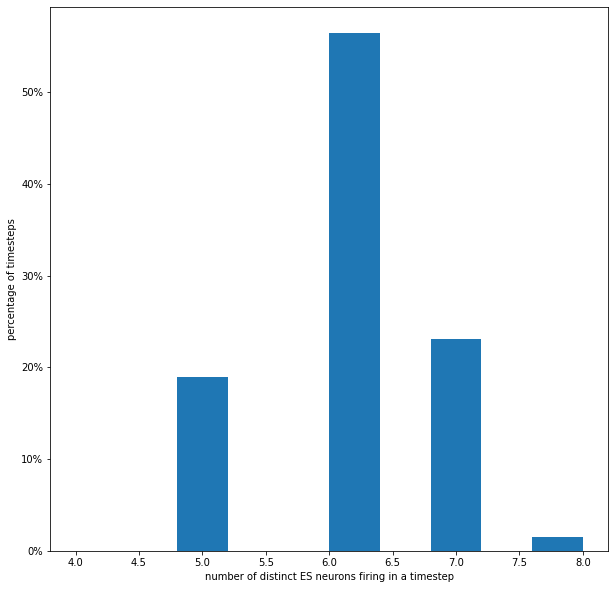

In [173]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

plt.figure(figsize=(10,10))
# plt.boxplot()
d = [len(set(v)) for k,v in es_spks_at_times.items()][3:]
t_d = sum(d)
plt.hist(d, weights=np.ones(len(d)) / len(d))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('number of distinct ES neurons firing in a timestep')
plt.ylabel('percentage of timesteps')
plt.show()

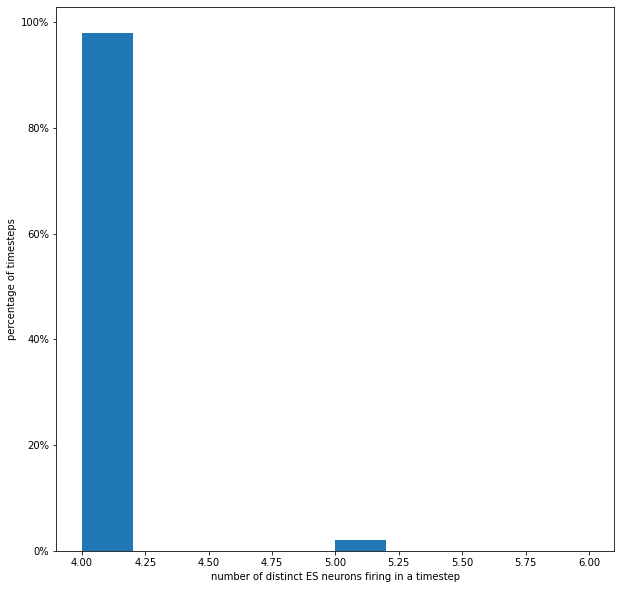

In [204]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

plt.figure(figsize=(10,10))
# plt.boxplot()
d = [len(set(v)) for k,v in es_spks_at_times.items()][3:]
# d = [len(v) for k,v in es_spks_at_times.items()][3:]
t_d = sum(d)
plt.hist(d, weights=np.ones(len(d)) / len(d))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('number of distinct ES neurons firing in a timestep')
plt.ylabel('percentage of timesteps')
plt.show()

In [127]:
[len(set(v)) for k,v in es_spks_at_times.items()][4:]

[2,
 3,
 2,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 5,
 4,
 4,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [163]:
len([s for s in [len(set(v)) for k,v in es_spks_at_times.items()] if s == 5]) / len([len(set(v)) for k,v in es_spks_at_times.items()])

0.029017857142857144